In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from prediction.data import vessel_groups
from prediction.preprocessing import load_and_build, remove_outliers_parallel
from prediction.preprocessing.trajectory_resampling import compare_trajectory_pairs, resample_trajectories
from prediction.visualization import plot_north_america, plot_trajectories

/Users/marcus/Documents/Workspace/python-envs/ais-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Resample Data (Needs to be run only once)

1. Load the data
2. Remove outliers
3. Convert the time data to seconds
4. Resample the data to 5 minutes intervals
6. Save both the original and resampled data

In [6]:
groups = vessel_groups()
trajectories = load_and_build(datetime(2024, 1, 1), datetime(2024, 1, 1), 100, groups, verbose=True)
trajectories = remove_outliers_parallel(
    df=trajectories,
    threshold_partition_sog=5.0,
    threshold_association_sog=15.0,
    threshold_completeness=100.0,
    threshold_partition_distance=100.0,
    threshold_association_distance=100.0,
)

Loading and building trajectories for 1 days using 11 processes
Loading and building trajectories for 2024-01-01 00:00:00


100%|██████████| 14868/14868 [02:11<00:00, 112.96it/s]


Processing with 11 processes...


100%|██████████| 1097/1097 [08:26<00:00,  2.17it/s]


In [ ]:
# convert timestamps (list of datetimes) to seconds (each cell in datetimes contains list of datetimes)
trajectories["timestamps"] = trajectories["timestamps"].apply(
    lambda x: [int((t - min(x)).total_seconds()) for t in x]
)

In [30]:
trajectories["point_count"] = trajectories["orientations"].apply(len)
trajectories.to_pickle("trajectories.pkl")

In [33]:
trajectories_resampled = resample_trajectories(trajectories, 5)

/Users/marcus/Documents/Workspace/python-envs/ais-env/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [34]:
trajectories_resampled.to_pickle("trajectories_resampled.pkl")

## Analyse Resampled Data

1. Load the resampled and original data
2. Plot the resampled data vs the original data
3. Compute similarities between the resampled and original data
4. Print similarity metrics
5. Plot example of samples that are dissimilar

In [3]:
trajectories = pd.read_pickle("trajectories.pkl")
trajectories_resampled = pd.read_pickle("trajectories_resampled.pkl")

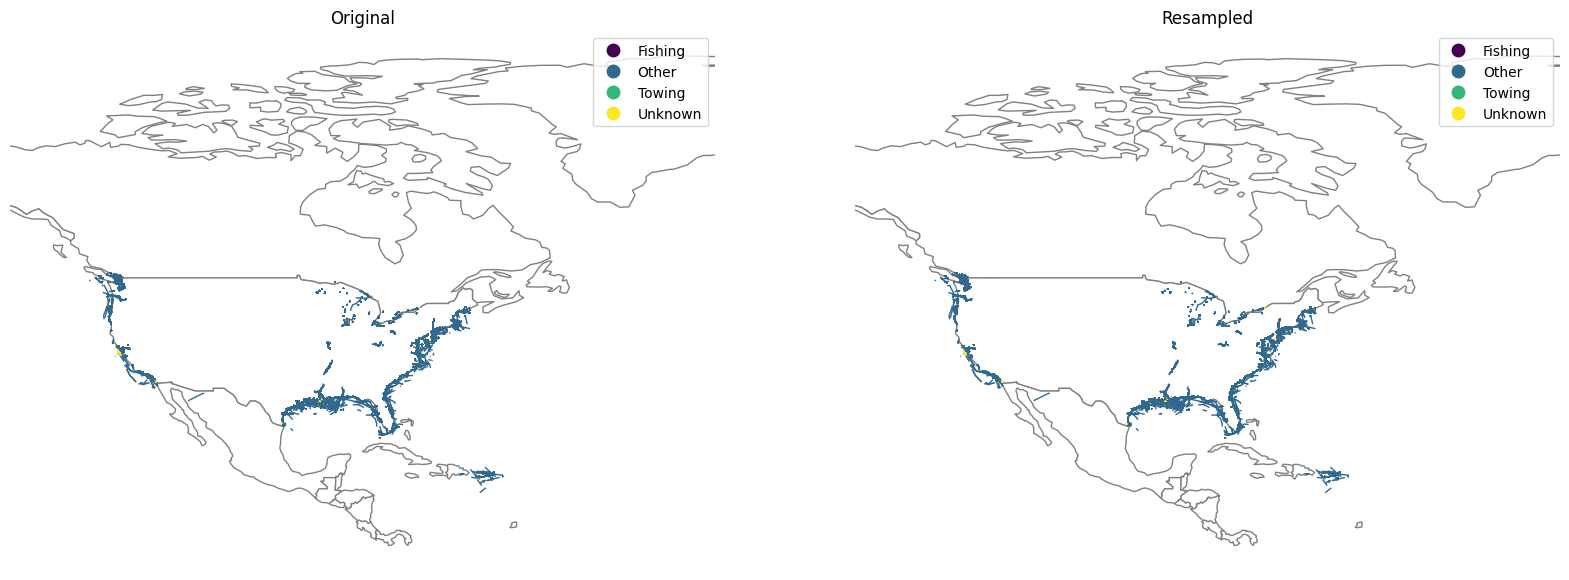

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].set_axis_off()
plot_north_america(ax[0])
plot_trajectories(trajectories, ax[0])
ax[0].set_xlim(-140, -30)
ax[0].set_title("Original")

ax[1].set_axis_off()
plot_north_america(ax[1])
plot_trajectories(trajectories_resampled, ax[1])
ax[1].set_xlim(-140, -30)
ax[1].set_title("Resampled")

plt.show()

In [4]:
results_df = compare_trajectory_pairs(trajectories, trajectories_resampled, n_processes=11)
results_df.to_csv("trajectory_comparison_results.csv")

100%|██████████| 1098/1098 [01:21<00:00, 13.54it/s]


In [5]:
print(results_df.describe())

               mmsi  trajectory_id  dtw_distance  avg_point_distance  \
count  1.208700e+04   12087.000000  12087.000000        12087.000000   
mean   3.650187e+08     548.094564     85.205140            0.281280   
std    5.581416e+07     317.208187    327.374744            1.341614   
min    0.000000e+00       0.000000      0.000000            0.000000   
25%    3.384451e+08     273.000000      0.603733            0.001453   
50%    3.674169e+08     548.000000      1.838088            0.003246   
75%    3.680835e+08     823.000000     36.374294            0.081928   
max    1.072211e+09    1097.000000   9055.283626           33.914920   

       path_length_ratio  original_points  resampled_points  
count       12087.000000     12087.000000      12087.000000  
mean            0.432490       531.329445        259.330107  
std             0.228582       364.744580         63.622704  
min             0.000000       100.000000         22.000000  
25%             0.271777       287.000000

In [6]:
results_df["resampling_ratio"] = results_df["original_points"] / results_df["resampled_points"]
print(results_df.nlargest(10, "dtw_distance"))

          mmsi  trajectory_id  dtw_distance  avg_point_distance  \
113  367327360            113   9055.283626           33.914920   
136  368064690            136   6889.106756           30.083436   
686  538007181            686   5553.535366           16.050680   
326  367561730            326   5426.914541           20.025515   
879  368013040            879   4888.013175           16.972268   
740  367453940            740   4617.368748           15.652097   
990  636018102            990   4293.027386           15.611009   
144  367533290            144   4204.421601           15.400812   
896  565475000            896   4202.528585           21.332632   
234  369142000            234   4069.160429           15.240301   

     path_length_ratio  original_points  resampled_points  resampling_ratio  
113           0.535581              124               267          0.464419  
136           0.467249              122               229          0.532751  
686           0.167630      

According to the output of the previous cell, the following trajectory is dissimilar to the original data but looking at the plot, it seems to be a valid trajectory. This is because the similarity metrics are not perfect and there is a trade-off between the similarity and the number of samples.

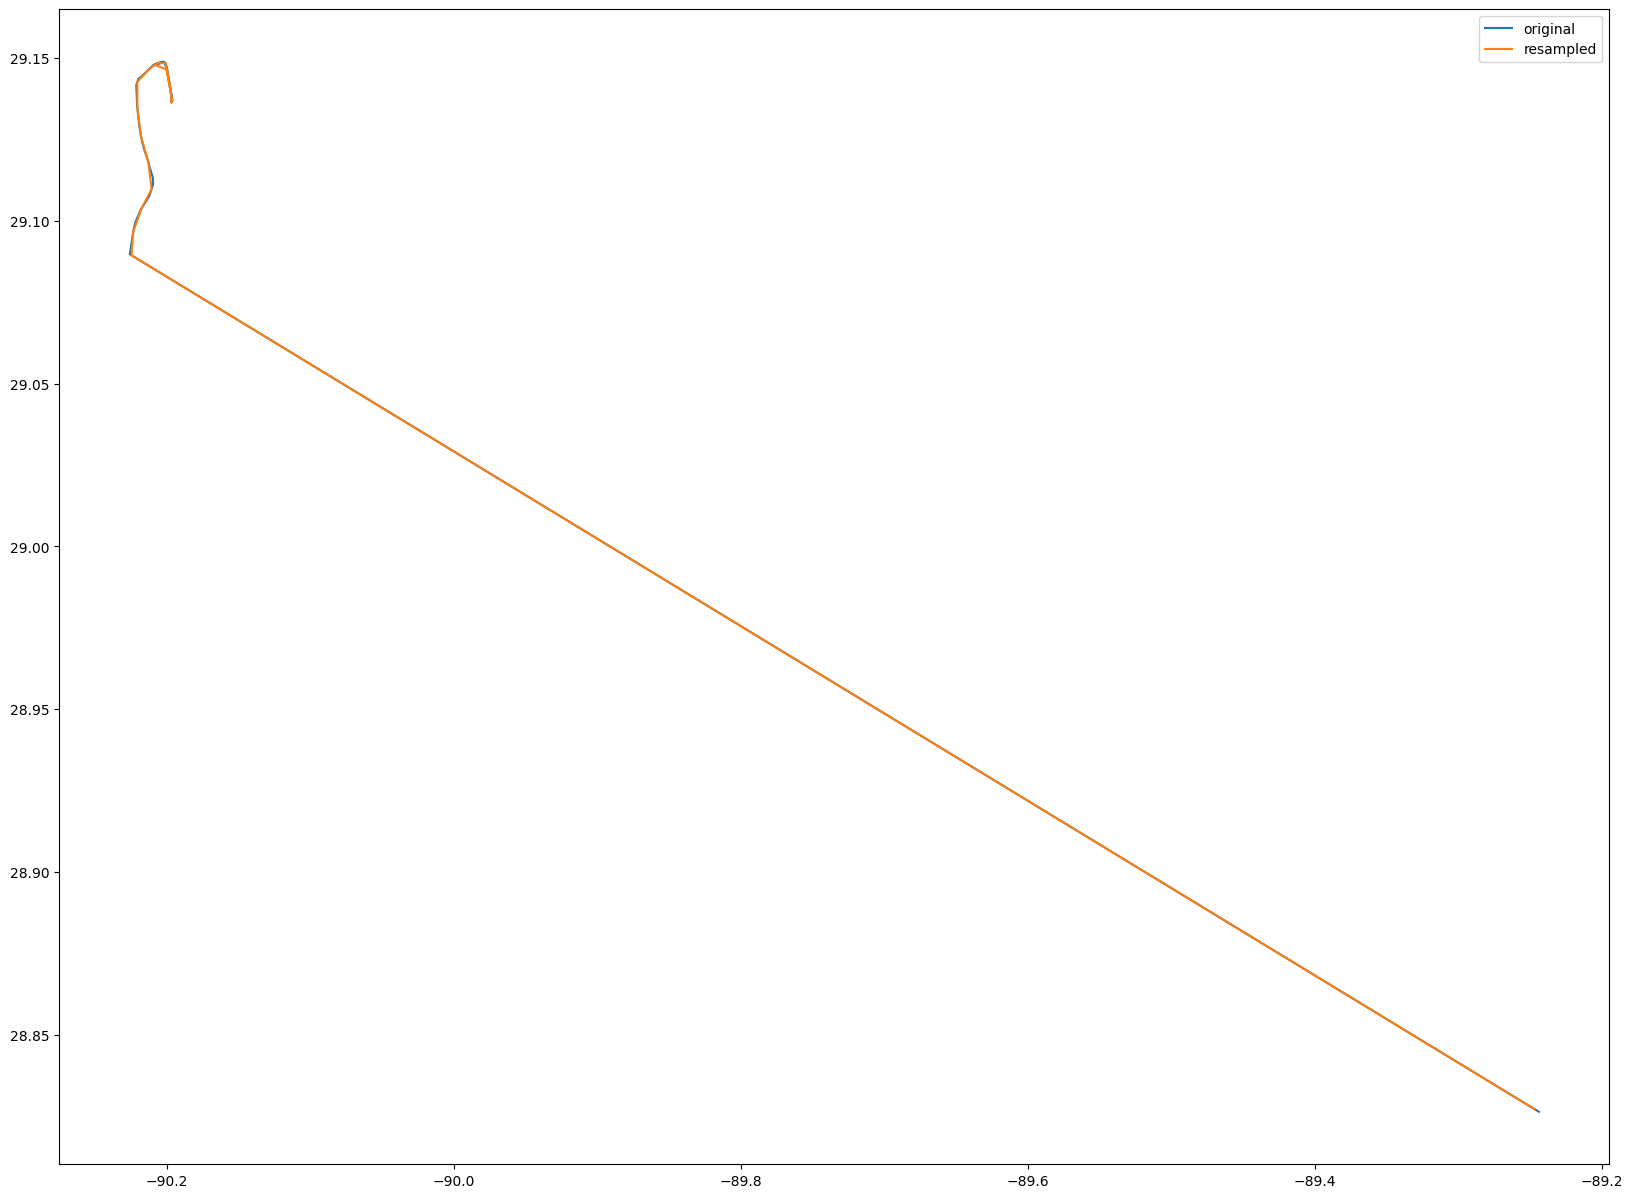

In [5]:
# plot trajectory with mmsi and its resampled version
mmsi = 367327360
fig, ax = plt.subplots(figsize=(20, 15))
orig_568 = trajectories[trajectories["mmsi"] == mmsi].iloc[0]
resampled_568 = trajectories_resampled[trajectories_resampled["mmsi"] == mmsi].iloc[0]

orig_568_coords = np.array(orig_568["geometry"].coords).T
resampled_568_coords = np.array(resampled_568["geometry"].coords).T

ax.plot(orig_568_coords[0], orig_568_coords[1], label="original")
ax.plot(resampled_568_coords[0], resampled_568_coords[1], label="resampled")

# set limits to x [-90.3, -90.1] and y [29.07, 29.17]
# ax.set_xlim(-90.23, -90.19)
# ax.set_ylim(29.1, 29.15)

ax.legend()
plt.show()